In [1]:
from matplotlib import pylab

from archeoview.utils import geotiff_to_numpy, minmax_scaling
from archeoview.pca import pca_decomposition

# PCA on GeoTiff

The aim of this notebook is to read in a `GeoTiff` raster of information and decompose all the bands into a single image through [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis).

### Import image and convert to numerical arrays

In [2]:
band_names, image = geotiff_to_numpy("data/20180807-kortgene/")
height, width, bands = image.shape
band_names, image.shape

(['WVP', 'AOT', 'B4', 'B3', 'B8', 'B2'], (174, 252, 6))

Let's try displaying band "WVP"

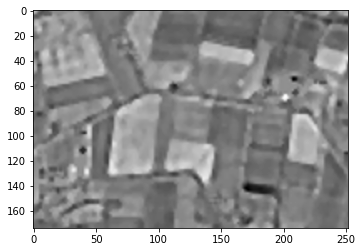

In [3]:
wvp = image[:, :, 0]
pylab.imshow(wvp, cmap="gray")

### Apply PCA to all data

We use the function defined in `archeoview/pca.py`, which returns us the final image and the ratio of explained variance from PCA

In [4]:
pca_image, ratio = pca_decomposition(image)
ratio

0.9937066463857275

We can now display the images with matplotlib, playing with which band to assing to each colour by simply reordering the bands in the output

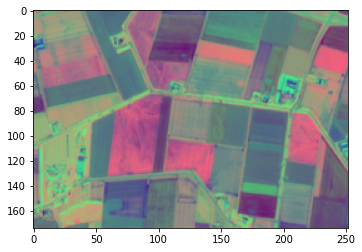

In [5]:
pylab.imshow(pca_image)

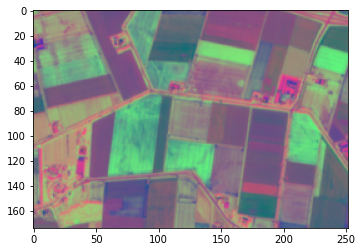

In [6]:
pylab.imshow(pca_image[:, :, [1, 0, 2]])

And finally, save the image

In [7]:
pylab.imsave("out/pca/20180807-kortgene.png", pca_image[:, :, [1, 0, 2]])

For comparison, here is the original image with the original RGB bands (respectively B2, B3 and B4)

In [ ]:
pca_image, ratio = pca_decomposition(image)

In [9]:
pylab.imsave("out/original/20180807-kortgene.png", original_image)

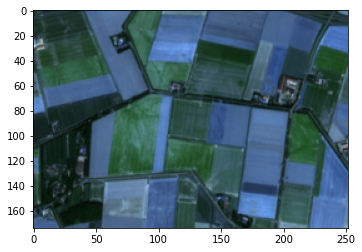

In [8]:
bands_idx = [band_names.index(band_name) for band_name in ["B2", "B3", "B4"]]
original_image = minmax_scaling(image[:, :, bands_idx])
pylab.imshow(original_image)